# Pre Processing Values

In [5]:
sample_size = 2000 # Number of Sequences to take from each Run
min_seq_len = 85
max_seq_len = 200

# Imports

In [6]:
# https://pysam.readthedocs.io/en/latest/usage.html
import pysam
import pandas
import sys
import os
import subprocess
import seaborn
import glob
import numpy
import matplotlib.pyplot as plt
import warnings
from numpy import unravel_index
warnings.filterwarnings('ignore')

# Functions

In [7]:
def create_training_data(infile, project_id=None, run_accession=None):

  try:
    samfile = pysam.AlignmentFile(infile, "r")
    _ = samfile.fetch()
    samfile.close()
  except:
    samfile.close()
    cmd = [ my_local_path +"samtools/bin/samtools",
      "index", infile
      ]
    print("Running Command: ", *cmd)
    subprocess.run(cmd)
    
  samfile = pysam.AlignmentFile(infile, "r")
  unmapped = []
  for read in samfile.fetch():
    
    if (read.is_unmapped) or (read.flag == 0):
      unmapped.append(read.to_dict())
 
  if len(unmapped) > 0:
    df = pandas.DataFrame.from_records(unmapped)
    df = df.sort_values(by=['name'], ascending=True, ignore_index=True)
    df = df.assign(project_id=project_id)
    df = df.assign(run_accession=run_accession)
    samfile.close()
    return df
  else:
    print("No Unmapped Reads For: Project->{} Run->{}".format(project_id,run_accession ))
    return None

In [8]:
def build_kmers(sequence, ksize):
    kmers = []
    n_kmers = len(sequence) - ksize + 1

    for i in range(n_kmers):
        kmer = sequence[i:i + ksize]
        kmers.append(kmer)

    return kmers

# https://neo4j.com/docs/graph-data-science/current/alpha-algorithms/jaccard/
def jaccard_similarity(a, b):
    """
    Jaccard Similarity (coefficient), a term coined by Paul Jaccard, 
    measures similarities between sets. It is defined as the size of the 
    intersection divided by the size of the union of two sets. 
    This notion has been generalized for multisets, 
    where duplicate elements are counted as weights.
    """

    a = set(a)
    b = set(b)

    intersection = len(a.intersection(b))
    union = len(a.union(b))

    return intersection / union


def jaccard_containment(a, b):
    a = set(a)
    b = set(b)

    intersection = len(a.intersection(b))

    return intersection / len(a)
    
def read_kmers_from_list(array, ksize):
  all_kmers = []
  for sequence in array:
    kmers = build_kmers(sequence, ksize)
    all_kmers += kmers
  return all_kmers
def cosine_similarity(arr1, arr2):
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.metrics.pairwise import cosine_similarity

    count_vectorizer = CountVectorizer()
    vector_matrix = count_vectorizer.fit_transform([' '.join(str(x) for x in arr1), ' '.join(str(x) for x in arr2)])
    tokens = count_vectorizer.get_feature_names()
    cosine_similarity_matrix = cosine_similarity(vector_matrix)
    
    return cosine_similarity_matrix[0][1]


In [9]:
def get_location_data(project_ID):
    import requests
    import json
    import pandas
    url = 'https://www.ebi.ac.uk/ena/portal/api/filereport'
    params = {'accession':"{}".format(project_ID),
              'fields':"center_name,instrument_platform,instrument_model,host",
            'format':'json',
            'download':'false',
            'result':'read_run'}
    
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"+
             " AppleWebKit/537.36 (KHTML, like Gecko)"+
             " Chrome/70.0.3538.77 Safari/537.36"}

    print("Accessing: ", url)
    r = requests.get(url,
                  params = params,
                  headers = headers
                  ) 
    print("\tMaking Request To: ", r.url) 
    my_json = json.loads(r.text)
    df = pandas.json_normalize(json.loads(r.text))
    df = df.assign(project_id=project_ID)
    
    # Temp Fix if center_name field is empty
    df['center_name'] = df['center_name'].replace('', project_ID)
    return df

# Main

## SetUp

In [10]:
my_local_path = "/gpfs/gpfs0/project/ds6011-sp22-wiki-data/ds6011-sp22-dod/"
bam_files_path = ''.join([my_local_path, "data/bam_files" ])
csv_files_path = ''.join([my_local_path, "data/csv_files" ])

In [11]:
projects  = glob.glob("{}/*".format(bam_files_path), recursive = True)
projects = [x.split("/")[-1] for x in projects]
#projects = ['PRJNA784038','PRJNA281708','PRJNA634526','PRJNA277616','PRJNA694172']
projects = ['PRJNA281708','PRJNA634526','PRJNA277616']

In [12]:
frames = []
for project in projects:
    for myfile in os.listdir("{}/{}".format(bam_files_path,project)):
        if not myfile.endswith(".bam"): 
            continue
        if myfile.endswith("_sorted.bam"):
            continue
        if myfile == ".bam": continue # Not sure what this file is
        #print(myfile)
        print("Reading Unmapped Reads For: Project->{} Run->{}".format(project,myfile.split(".")[0] ))
        bamfile = "{}/{}/{}".format(bam_files_path,project,myfile)
        if os.path.exists("{}/{}_{}.csv".format(csv_files_path,project,myfile[:-4])):
            try:
                print("\t Reading CSV to frame")
                frame = pandas.read_csv("{}/{}_{}.csv".format(csv_files_path,project,myfile[:-4]))
                if 'Unnamed: 0' in list(frame.columns):
                    frame.drop('Unnamed: 0', axis=1, inplace=True)
            except:
                # Remove Old CSV if it cannot be read
                print("\tError reading CSV - Generating new frame")
                os.remove("{}/{}_{}.csv".format(csv_files_path,project,myfile[:-4]))
                frame = create_training_data(bamfile, project, myfile.split(".")[0])
                if frame is not None:
                    frame.to_csv("{}/{}_{}.csv".format(csv_files_path,project,myfile[:-4]), encoding='utf-8')
                
        else:
            print("\t Generating frame")
            frame = create_training_data(bamfile, project, myfile.split(".")[0])
            if frame is not None:
                frame.to_csv("{}/{}_{}.csv".format(csv_files_path,project,myfile[:-4]), encoding='utf-8')
        if frame is not None:
            frames.append(frame)
        #    if len(frames) == 3:
        #        break
        print()


Reading Unmapped Reads For: Project->PRJNA281708 Run->SRR1982585
	 Reading CSV to frame

Reading Unmapped Reads For: Project->PRJNA281708 Run->SRR1982584
	 Reading CSV to frame

Reading Unmapped Reads For: Project->PRJNA281708 Run->SRR1982612
	 Reading CSV to frame

Reading Unmapped Reads For: Project->PRJNA281708 Run->SRR1982660
	 Reading CSV to frame

Reading Unmapped Reads For: Project->PRJNA281708 Run->SRR1982826
	 Reading CSV to frame

Reading Unmapped Reads For: Project->PRJNA281708 Run->SRR1982787
	 Reading CSV to frame

Reading Unmapped Reads For: Project->PRJNA281708 Run->SRR1982783
	 Reading CSV to frame

Reading Unmapped Reads For: Project->PRJNA281708 Run->SRR1982588
	 Reading CSV to frame

Reading Unmapped Reads For: Project->PRJNA281708 Run->SRR1982727
	 Reading CSV to frame

Reading Unmapped Reads For: Project->PRJNA281708 Run->SRR1982814
	 Reading CSV to frame

Reading Unmapped Reads For: Project->PRJNA634526 Run->SRR14209614
	 Reading CSV to frame

Reading Unmapped Rea

### Subset Data

In [13]:
print("Number of Runs: ", len(frames))
print("Number of Sequences: {:,}".format(sum([df.shape[0] for df in frames])))

Number of Runs:  28
Number of Sequences: 101,143,062


In [14]:
temp_frames = []
for df in frames:
    if df.shape[0] >= sample_size:
        temp_frames.append(df.sample(sample_size) )
print(len(temp_frames))

27


In [15]:
train_frames = temp_frames

In [16]:
print("Number of Subset Sequences: {:,}".format(sum([df.shape[0] for df in train_frames])))

Number of Subset Sequences: 54,000


In [17]:
db = pandas.concat(train_frames, ignore_index=True)
db.shape

(54000, 14)

### Find length of Each Sequence

In [18]:
db['seq_len'] = db['seq'].apply(lambda x: len(x))

### Remove Rows with Small Sequences

In [19]:
db = db.query('seq_len > {}'.format(min_seq_len))

In [20]:
db = db[~db['project_id'].isin(['PRJNA298963'])]

In [21]:
db.shape

(53261, 15)

# Test Train Split

In [22]:
db = db.set_index(['project_id', 'run_accession'])

In [23]:
db = db.reset_index()
db

,project_id,run_accession,name,flag,ref_name,ref_pos,map_quality,cigar,next_ref_name,next_ref_pos,length,seq,qual,tags,seq_len
0,PRJNA281708,SRR1982585,SRR1982585.19285911,0,7,10933599,60,94M4397N6M,*,0,0,CTTCATTCTAAAGCAGCGTTATAGTGAAACATTTCATTTAGAAATC...,CCCFFFFFHDDDHIGIIFGIIIIIIIB>HHIIIIIIIIIIIIIIII...,"['AS:i:0', 'XN:i:0', 'XM:i:0', 'XO:i:0', 'XG:i...",100
1,PRJNA281708,SRR1982585,SRR1982585.14467585,0,MT,3495,60,95M858N5M,*,0,0,CGCCACATCTACCATCACCCTCTACATCACCGCCCCGACCTTAGCT...,CCCFFFFFGHHHHJJJJJJJJJJJJIJJJJJJJJJJHGIJGIIIII...,"['AS:i:-5', 'ZS:i:-14', 'XN:i:0', 'XM:i:1', 'X...",100
2,PRJNA281708,SRR1982585,SRR1982585.11101432,0,GL000220.1,110225,1,100M,*,0,0,AAAGTCTTTGGGTTCCGGGGGGAGTATGGTTGCAAAGCTGAAACTT...,@BCFBDFFHHHHHGIJJJJGID:B8ACDDDCDDDDDDDDDDDDDDD...,"['AS:i:0', 'ZS:i:0', 'XN:i:0', 'XM:i:0', 'XO:i...",100
3,PRJNA281708,SRR1982585,SRR1982585.12256500,0,18,3255989,60,100M,*,0,0,CCTTAGCTTTACAGCTTTTGCATTTCCTGTTGTATTTATTCTCAGC...,??;D=DDDHHFA?<CA<EF<CFADFHHAFHGCD@HHGHGACGFHGI...,"['AS:i:0', 'XN:i:0', 'XM:i:0', 'XO:i:0', 'XG:i...",100
4,PRJNA281708,SRR1982585,SRR1982585.8205913,0,19,5611601,60,30M909N28M897N42M,*,0,0,CCCCCAAAATGTCGAGTATTTTCTCATTTTCTGGCTCCAAAAGGGA...,CCCFFDFFHHHHHIII2CHHIJGEFEIJJJAFEHGIGIEHIIBHIG...,"['AS:i:0', 'XN:i:0', 'XM:i:0', 'XO:i:0', 'XG:i...",100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53256,PRJNA277616,SRR1926136,SRR1926136.8578247,133,2,69869763,0,*,=,69869763,0,ACTTACACCAATCGATACATCATTTTCAAACGCAATACACTGAATC...,FFFFFFFFFFIIIIIIIIIIIIIIIIIIIIIIIIIIIFIIIFFIII...,['YT:Z:UP'],98
53257,PRJNA277616,SRR1926136,SRR1926136.13149211,133,MT,1796,0,*,=,1796,0,TGAAAAATTATAACCAAGCATAATATAGCAAGGACTAACCCCTATA...,FFFFFFFFFFIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,['YT:Z:UP'],98
53258,PRJNA277616,SRR1926136,SRR1926136.11371191,133,10,17235339,0,*,=,17235339,0,AGGAAAAGTTTGGAAGAGGCAGAGAAGACCTGCTCAATGTTAAGAT...,FFFFFFFFFFIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,['YT:Z:UP'],98
53259,PRJNA277616,SRR1926136,SRR1926136.12620085,69,17,29573784,0,*,=,29573784,0,CTGGCTCCCCGGGGTCCCCGACTCAGCTGGTGGCTGTGGAGCTGAG...,FFFFFFFFFIIIIIFFIIIIIIIIIIIIIIFFFIIIFFIIFFFFFF...,['YT:Z:UP'],100


In [24]:
stratval = db.groupby('project_id').agg('count')['run_accession'].min()

In [25]:
from sklearn.model_selection import train_test_split
db = db.groupby('project_id', group_keys=False).apply(lambda x: x.sample(stratval))

In [26]:
db = db.set_index(['project_id', 'run_accession'])

In [27]:
#db, test = train_test_split(db, test_size=0.2, stratify=project_id)
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
#db, test = train_test_split(db, test_size=0.2)
db, test = train_test_split(db, test_size=0.2)

### Quick view of Data

In [28]:
db.sample(5)

name  flag ref_name    ref_pos  \
project_id  run_accession                                                   
PRJNA281708 SRR1982787       SRR1982787.5323711     0       MT      15353   
            SRR1982585       SRR1982585.3007597     0        6    6144909   
PRJNA634526 SRR14209634     SRR14209634.3432005    69        3  140490011   
            SRR14209614     SRR14209614.2398524    69       12   53498908   
            SRR14209634    SRR14209634.14460128   133        6  118519448   

                           map_quality  cigar next_ref_name  next_ref_pos  \
project_id  run_accession                                                   
PRJNA281708 SRR1982787              60  99M1S             *             0   
            SRR1982585              60   100M             *             0   
PRJNA634526 SRR14209634              0      *             =     140490011   
            SRR14209614              0      *             =      53498908   
            SRR14209634              0      *             =     118519448   

                           length  \
project_id  run_accession           
PRJNA281708 SRR1982787          0   
            SRR1982585          0   
PRJNA634526 SRR14209634         0   
            SRR14209614         0   
            SRR14209634         0   

                                                                         seq  \
project_id  run_accession                                                      
PRJNA281708 SRR1982787     ACGGGATCAAACAACCCCCTAGGAATCACCTCCCATTCCGATAAAA...   
            SRR1982585     TAAAATGCATCACAAAACTACATTATTCAATAGACTTGAGTGTTGC...   
PRJNA634526 SRR14209634    TGGGAGTGTGGCAGCTGCTGATGCTGCCGTTTGGCTCCTGCGTGGT...   
            SRR14209614    GTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGT...   
            SRR14209634    AGAAGATTAACTAGATTAAGACCAGGGGGCAGTAAAGATAGAAACG...   

                                                                        qual  \
project_id  run_accession                                                      
PRJNA281708 SRR1982787     <=?DFDDDBHFHHJGIGIIIIEFFHHIHIHEHIJGIHGGIGEHGIH...   
            SRR1982585     CCCFFFFFHHHGHEAGBHIIIIIIIIIIIIIIIIIIIIIIDGGHII...   
PRJNA634526 SRR14209634    FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFF...   
            SRR14209614    FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF...   
            SRR14209634    FFFFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFFF,FFFFF,FFFF...   

                                                                        tags  \
project_id  run_accession                                                      
PRJNA281708 SRR1982787     ['AS:i:-1', 'XN:i:0', 'XM:i:0', 'XO:i:0', 'XG:...   
            SRR1982585     ['AS:i:0', 'XN:i:0', 'XM:i:0', 'XO:i:0', 'XG:i...   
PRJNA634526 SRR14209634                                          ['YT:Z:UP']   
            SRR14209614                                          ['YT:Z:UP']   
            SRR14209634                                          ['YT:Z:UP']   

                           seq_len  
project_id  run_accession           
PRJNA281708 SRR1982787         100  
            SRR1982585         100  
PRJNA634526 SRR14209634        150  
            SRR14209614        114  
            SRR14209634        123

In [29]:
db.head(1).T

project_id,PRJNA277616
run_accession,SRR1926132
name,SRR1926132.13106614
flag,133
ref_name,16
ref_pos,30069923
map_quality,0
cigar,*
next_ref_name,=
next_ref_pos,30069923
length,0


In [30]:
db.groupby(level=['project_id','run_accession']).size()

project_id   run_accession
PRJNA277616  SRR1867792       1095
             SRR1909613       1079
             SRR1909637       1054
             SRR1909638       1059
             SRR1909639       1038
             SRR1926132       1112
             SRR1926133       1050
             SRR1926134       1049
             SRR1926135       1034
             SRR1926136       1076
PRJNA281708  SRR1982584       1009
             SRR1982585       1063
             SRR1982588       1040
             SRR1982612       1076
             SRR1982660       1064
             SRR1982727       1070
             SRR1982783       1042
             SRR1982787       1094
             SRR1982814       1055
             SRR1982826       1094
PRJNA634526  SRR14209589      1534
             SRR14209591      1512
             SRR14209592      1509
             SRR14209614      1509
             SRR14209634      1523
             SRR14209655      1495
             SRR14209708      1491
dtype: int64

# K-Mer Optimze

In [31]:
df = pandas.concat([get_location_data(x) for x in projects], ignore_index=True)
df

Accessing:  https://www.ebi.ac.uk/ena/portal/api/filereport
	Making Request To:  https://www.ebi.ac.uk/ena/portal/api/filereport?accession=PRJNA281708&fields=center_name%2Cinstrument_platform%2Cinstrument_model%2Chost&format=json&download=false&result=read_run
Accessing:  https://www.ebi.ac.uk/ena/portal/api/filereport
	Making Request To:  https://www.ebi.ac.uk/ena/portal/api/filereport?accession=PRJNA634526&fields=center_name%2Cinstrument_platform%2Cinstrument_model%2Chost&format=json&download=false&result=read_run
Accessing:  https://www.ebi.ac.uk/ena/portal/api/filereport
	Making Request To:  https://www.ebi.ac.uk/ena/portal/api/filereport?accession=PRJNA277616&fields=center_name%2Cinstrument_platform%2Cinstrument_model%2Chost&format=json&download=false&result=read_run


,run_accession,sample_accession,center_name,instrument_platform,instrument_model,host,project_id
0,SRR1982584,SAMN03495628,GEO,ILLUMINA,Illumina HiSeq 2500,,PRJNA281708
1,SRR1982585,SAMN03495629,GEO,ILLUMINA,Illumina HiSeq 2500,,PRJNA281708
2,SRR1982586,SAMN03495630,GEO,ILLUMINA,Illumina HiSeq 2500,,PRJNA281708
3,SRR1982587,SAMN03495631,GEO,ILLUMINA,Illumina HiSeq 2500,,PRJNA281708
4,SRR1982588,SAMN03495632,GEO,ILLUMINA,Illumina HiSeq 2500,,PRJNA281708
...,...,...,...,...,...,...,...
416,SRR1926132,SAMN03394587,Weill Cornell Medical College in Qatar,ILLUMINA,Illumina HiSeq 2500,,PRJNA277616
417,SRR1926133,SAMN03394586,Weill Cornell Medical College in Qatar,ILLUMINA,Illumina HiSeq 2500,,PRJNA277616
418,SRR1926134,SAMN03394585,Weill Cornell Medical College in Qatar,ILLUMINA,Illumina HiSeq 2500,,PRJNA277616
419,SRR1926135,SAMN03394584,Weill Cornell Medical College in Qatar,ILLUMINA,Illumina HiSeq 2500,,PRJNA277616


In [32]:
avg_seq_len = int(db.seq_len.mean())

In [33]:
kmin = int(avg_seq_len * 1./4)
kmax = int(avg_seq_len * 3./4)
ntopics_min = 12
ntopics_max = 40
print(kmin,kmax)

28 84


In [34]:
import random
import gensim
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora
from pprint import pprint
import time

def clean_seq(sequences, K):
    tmp = []
    nucleotides = [x*K for x in ['A','C','G','T','N']]
    ##### BEGIN TEST WITH DOUBLES #####
    #from itertools import combinations
    #combs = list(combinations(['A','C','G','T','N'], 2))
    #temp = [ "{}{}".format(x[0],x[1]) for x in combs] + [ "{}{}".format(x[1],x[0]) for x in combs]
    #temp = [x*K for x in temp]
    #temp = [x[:K] for x in temp]
    #nucleotides = nucleotides + temp
    ##### END TEST WITH DOUBLES #####
    #print(nucleotides)
    for sequence in sequences:
        if any([True if repeated_nucleotide in sequence else False for repeated_nucleotide in nucleotides ]):
            continue
        else:
            tmp.append(sequence)   
    return tmp

db = db.sort_index()
indexes = sorted(list(set(db.index)))
N = len(indexes)

coherence_vals = []
KS = []
ntopics_arr = []
done_list = []
avg_seq_len = int(db.seq_len.mean())
for i in range(70):
    
    #K = random.randint(int(avg_seq_len * 1./3), int(avg_seq_len * 2./3))
    K = random.randint(kmin, kmax)
    ntopics = random.randint(ntopics_min, ntopics_max)
    complete = (K,ntopics)
    if complete in done_list:
        continue
    done_list.append(complete)
    print("Iteration ",i+1)
    print("\tTesting: K-> {}, Num Topics-> {}".format( K,ntopics))
    start = time.time()
    mydict = {}

    for i in range(N):
        key = indexes[i]
        seq = db.loc[key]['seq'].to_list()
        seq = clean_seq(seq, K)
        arr = read_kmers_from_list(seq, K)
        mydict[key] = arr
    
    text_tokens = []
    for key in mydict.keys():
        seq = mydict[key]
        text_tokens.append(seq)
    # Create Dictionary
    id2word = corpora.Dictionary(text_tokens)
    # Create Corpus
    texts = text_tokens
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]

    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=ntopics)
    cm = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
    coherence = cm.get_coherence()
    end = time.time()
    print("\tElapsed Time: {}s".format(str(end - start)) )
    coherence_vals.append(coherence)
    KS.append(K)
    ntopics_arr.append(ntopics)

Iteration  1
	Testing: K-> 30, Num Topics-> 36
	Elapsed Time: 43.9136164188385s
Iteration  2
	Testing: K-> 66, Num Topics-> 38
	Elapsed Time: 31.34852623939514s
Iteration  3
	Testing: K-> 50, Num Topics-> 24
	Elapsed Time: 28.341092824935913s
Iteration  4
	Testing: K-> 41, Num Topics-> 14
	Elapsed Time: 25.123136043548584s
Iteration  5
	Testing: K-> 83, Num Topics-> 37
	Elapsed Time: 20.390226364135742s
Iteration  6
	Testing: K-> 47, Num Topics-> 28
	Elapsed Time: 34.23981308937073s
Iteration  7
	Testing: K-> 80, Num Topics-> 31
	Elapsed Time: 22.56856417655945s
Iteration  8
	Testing: K-> 28, Num Topics-> 21
	Elapsed Time: 38.1758828163147s
Iteration  9
	Testing: K-> 32, Num Topics-> 25
	Elapsed Time: 34.802687883377075s
Iteration  10
	Testing: K-> 42, Num Topics-> 21
	Elapsed Time: 30.048315286636353s
Iteration  11
	Testing: K-> 36, Num Topics-> 38
	Elapsed Time: 43.74851870536804s
Iteration  12
	Testing: K-> 58, Num Topics-> 40
	Elapsed Time: 35.93093490600586s
Iteration  13
	Testing

In [35]:
coherence_vals = numpy.array(coherence_vals)
KS = numpy.array(KS)
ntopics_arr = numpy.array(ntopics_arr)

In [36]:
import pickle
pickle.dump([avg_seq_len,KS,ntopics_arr,coherence_vals ], open("optimize.p", "w+b"))

In [37]:
import pickle
avg_seq_len,KS,ntopics_arr,coherence_vals = pickle.load(open("optimize.p","rb"))

In [38]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

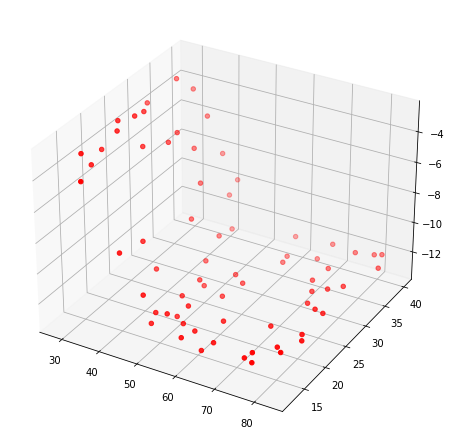

In [39]:
fig = plt.figure(figsize=(10,6))
ax = axes3d.Axes3D(fig)
ax.scatter3D(KS,ntopics_arr,coherence_vals, c='r');

In [40]:
import scipy as sp
import scipy.interpolate

Text(0.5, 0, 'Coherence')

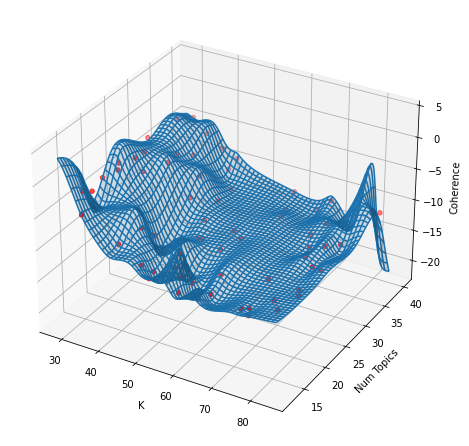

In [41]:
z = coherence_vals
x = KS
y = ntopics_arr
#x_grid = numpy.linspace(0, 132651, 1000*len(x))
x_grid = numpy.linspace(kmin, kmax, 2000)
#y_grid = numpy.linspace(0, 132651, 1000*len(y))
y_grid = numpy.linspace(ntopics_min, ntopics_max, 2000)
B1, B2 = numpy.meshgrid(x_grid, y_grid, indexing='xy')
Z = numpy.zeros((x.size, z.size))


spline = sp.interpolate.Rbf(x,y,z,function='thin_plate',smooth=5, episilon=5)

Z = spline(B1,B2)
fig = plt.figure(figsize=(10,6))
ax = axes3d.Axes3D(fig)
ax.plot_wireframe(B1, B2, Z)
ax.plot_surface(B1, B2, Z,alpha=0.2)
ax.scatter3D(x,y,z, c='r')
ax.set_xlabel("K")
ax.set_ylabel("Num Topics")
ax.set_zlabel("Coherence")

In [42]:
point = unravel_index(Z.argmin(), Z.shape)

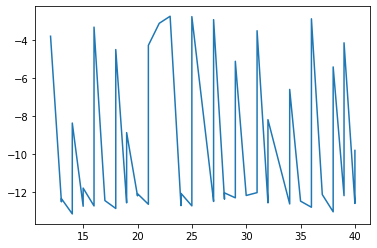

In [43]:
plt.figure()
y, z = zip(*sorted(zip(y, z)))
plt.plot(y,z)
plt.show()

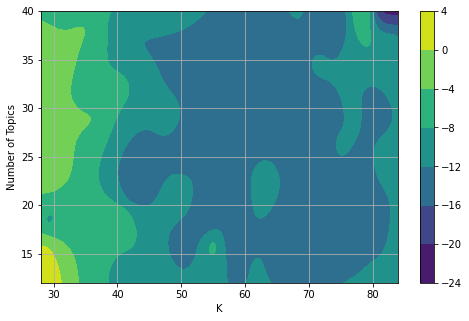

In [45]:
fig, ax = plt.subplots(figsize=(8,5))
plt.contourf(x_grid, y_grid, Z)
plt.xlabel("K")
plt.ylabel("Number of Topics")
plt.colorbar();
plt.grid()